In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf

tf.enable_eager_execution()
tf.set_random_seed(230)
print(tf.__version__)

from matplotlib import pyplot as plt

import sys
sys.path.append('..')

/Documents/venv3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


1.11.0


In [2]:
from configs.seq_fd_gru import hparams
hparams = hparams()
print(hparams)

[('batch_size', 800), ('datagen', 'prodn'), ('in_seq_len', 168), ('input_channels', 1), ('input_dim', 5), ('lambd', 1e-06), ('learning_rate', 0.001), ('logs_path', '/tmp/tensorflow_logs'), ('lr_decay', 0.99), ('neurons_unit', 32), ('norm_epsilon', 1e-12), ('num_layers', 1), ('out_seq_len', 24), ('output_channels', 1), ('output_dim', 1), ('test_split', 0.1), ('train_split', 0.8), ('val_split', 0.1)]


In [39]:
hparams=tf.contrib.training.HParams(
        batch_size=800,
        in_seq_len=168,
        input_dim=5,
        input_channels=1,
        out_seq_len=24,
        output_dim=1,
        output_channels=1,
        num_layers=1,
        neurons_unit=32,
        learning_rate = 10 ** -3,
        lr_decay = 0.99,
        lambd = 1e-6,
        train_split = 0.8,
        val_split = 0.1,
        test_split = 0.1,
        norm_epsilon = 1e-12,
        datagen = 'prodn',
        logs_path = '/tmp/tensorflow_logs')

In [6]:
from data_loader.biogas import *
get_fields = 'AT305'
dataset, dataset_val, dataset_test = load_data(hparams, mode=get_fields)
_, (inp, target, mask, x_max) = enumerate(dataset).__next__()

In [401]:
class pAttention(tf.keras.Model):
    def __init__(self):
        super(pAttention, self).__init__()
        self.W1 = tf.Variable(2., 'W_separation')
        self.W2 = tf.Variable(1., 'W_scale')

    def cov(self, x):

        n_dim  = tf.cast(tf.shape(x)[1], tf.float32) - 1
        mu_x   = x - tf.reduce_mean(x, axis=1, keep_dims=True)
        cov_xx = tf.matmul(mu_x, mu_x, transpose_a=True) / n_dim
        
        return cov_xx
    
    def call(self, x, hidden):
        cov = self.cov(x)
        cov = tf.reduce_sum(cov, axis=1)
        score = tf.exp(self.W1) * cov / tf.reduce_max(cov, axis=1, keep_dims=True)
        weights = tf.nn.softmax(score, axis=1)
        weights = tf.expand_dims(weights, axis=1)
        
        outputs = self.W2 * tf.reduce_mean(weights * tf.squeeze(hidden), axis=-1, keepdims=True) 
        
        return outputs

In [421]:
class MiniConvRNN(tf.keras.Model):
    def __init__(self, input_dim, output_dim, in_seq_len, out_seq_len, neurons_unit, batch_size, name=None):
        super(MiniConvRNN, self).__init__()

        self.input_dim    = input_dim
        self.output_dim   = output_dim
        self.in_seq_len   = in_seq_len
        self.out_seq_len  = out_seq_len
        self.neurons_unit = neurons_unit
        self.batch_size   = batch_size
        
        self.conv1_2x1  = tf.keras.layers.Conv1D(1, 2, padding='valid', activation='linear', use_bias=False)
        #self.conv1_36x1 = tf.keras.layers.Conv2D(1, (1,2), padding='valid', activation='linear')
        
        #self.conv2_2x1  = tf.keras.layers.Conv1D(2, 2, padding='valid', activation='tanh')
        #self.conv2_36x1 = tf.keras.layers.Conv2D(1, (1,2), padding='valid', activation='tanh')

        self.attn = pAttention()
        
    def reshape_deep(self, x):
        x = tf.reshape(x, [self.batch_size, self.input_dim, self.out_seq_len, -1])
        return tf.transpose(x, [0,2,1,3])
        
    def reshape_wide(self, x):
        x = tf.transpose(x, [0,2,1,3])
        return tf.reshape(x, [self.batch_size, self.input_dim * self.out_seq_len, -1])
    
    def encode(self, x):
        pos = self.out_seq_len * self.input_dim
        
        conv1 = self.conv1_2x1(x)
        #conv1 = self.conv1_36x1(tf.expand_dims(conv1,-1))

        #conv2 = self.conv2_2x1(tf.squeeze(conv1,-1))
        #conv2 = self.conv2_36x1(tf.expand_dims(conv2,-1))

        conv2 = tf.squeeze(conv1[:,-pos:])

        return self.reshape_deep(conv2)
        
    def call(self, inp, mask):
        
        enc_out = self.encode(inp)
        
        pos = self.out_seq_len * self.input_dim
        context = self.reshape_deep(inp[:,-pos:])
        context = self.attn(tf.squeeze(context), enc_out)
        context = tf.cumsum(context, axis=1)
        
        x = inp[:,-1:]

        return (x + context) * mask
        """output = x + tf.squeeze(tf.reduce_sum(enc_out,2))
        
        return tf.expand_dims(output, -1)
        
        pos = self.out_seq_len * self.input_dim
        context = self.reshape_deep(inp[:,-pos:])
        context = self.attn(tf.squeeze(context), enc_out)
        
        
        outputs = context + x
        
        return tf.expand_dims(outputs,-1)"""

In [423]:
_, (inp, target, mask, x_max) = enumerate(dataset).__next__()
model = MiniConvRNN(hparams.input_dim, hparams.output_dim, hparams.in_seq_len, hparams.out_seq_len,
               hparams.neurons_unit, hparams.batch_size)
conv1 = model.encode(inp)
#model.conv1_2x1.set_weights([np.array([[[-1.0]], [[ 1.0]]], dtype=np.float32),
#                             np.array([0.], dtype=np.float32)])
model.conv1_2x1.set_weights([np.array([[[-1.0]], [[ 1.0]]], dtype=np.float32)])
fcast = model.call(inp, mask)
conv1 = model.encode(inp)
cox = tf.cumsum(tf.squeeze(conv1))
fcast.shape, conv1.shape, cox.shape

(TensorShape([Dimension(800), Dimension(24), Dimension(1)]),
 TensorShape([Dimension(800), Dimension(24), Dimension(5), Dimension(1)]),
 TensorShape([Dimension(800), Dimension(24), Dimension(5)]))

In [446]:
atn  = pAttention().cov(tf.squeeze(model.reshape_deep(inp[:,-pos:])))
#atn_ = tf.reduce_sum(atn, axis=1)
atn_ = np.sum((atn / np.max(atn, axis=(1,2), keepdims=True)), axis=1)
act  = tf.nn.softmax(np.exp(0.5) * atn_, axis=1)
atn[160], atn_[160], act[160] * 100

(<tf.Tensor: id=4323585, shape=(5, 5), dtype=float32, numpy=
 array([[ 5.7195804e-05,  1.2064020e-05, -7.2434282e-06, -8.0919235e-05,
          1.3920855e-03],
        [ 1.2064020e-05,  2.5159632e-05,  2.3615910e-06, -4.1511354e-05,
          4.1423229e-04],
        [-7.2434282e-06,  2.3615910e-06,  2.5696303e-05,  1.0159341e-05,
          1.1175464e-04],
        [-8.0919235e-05, -4.1511354e-05,  1.0159341e-05,  1.8234426e-04,
         -1.6965274e-03],
        [ 1.3920855e-03,  4.1423229e-04,  1.1175464e-04, -1.6965274e-03,
          6.9401562e-02]], dtype=float32)>,
 array([ 0.01978605,  0.00594088,  0.00205656, -0.02343541,  1.0031922 ],
       dtype=float32),
 <tf.Tensor: id=4323590, shape=(5,), dtype=float32, numpy=
 array([11.185903 , 10.933456 , 10.86366  , 10.4165325, 56.600445 ],
       dtype=float32)>)

[<tf.Variable 'conv1d_60/kernel:0' shape=(2, 1, 1) dtype=float32, numpy=
array([[[-1.]],

       [[ 1.]]], dtype=float32)>]


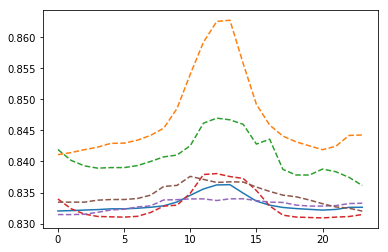

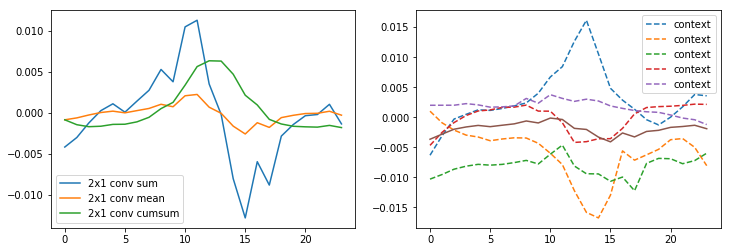

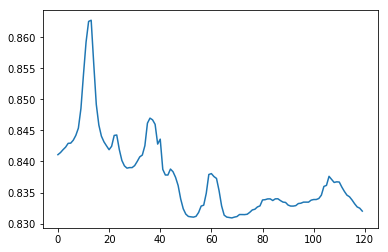

In [427]:
n = 24
pos = hparams.out_seq_len * hparams.input_dim
print(model.conv1_2x1.variables)

plt.plot(np.array(fcast[n]))
plt.plot(np.array(model.reshape_deep(inp[:,-pos:]))[n,:,:,0], '--')
plt.show()

plt.figure(figsize=(12,4))
ax = plt.subplot(1,2,1)
ax.plot(np.array(conv1[n]).sum(axis=(1)), label='2x1 conv sum')
ax.plot(np.array(conv1[n]).mean(axis=(1)), label='2x1 conv mean')
ax.plot(np.cumsum(conv1[n], axis=0).mean(axis=(1)), label='2x1 conv cumsum')
plt.legend()
ax = plt.subplot(1,2,2)
ax.plot(np.array(cox[n]), '--', label='context')
ax.plot(np.array(cox[n]).mean(axis=1))
plt.legend()
plt.show()

plt.plot(np.array(inp[n,-120:]))
plt.show()

In [20]:
_, (inp, target, mask, x_max) = enumerate(dataset).__next__()
model = ConvRNN(hparams.input_dim, hparams.output_dim, hparams.in_seq_len, hparams.out_seq_len,
                hparams.neurons_unit, hparams.batch_size)
conv1 = model(inp, mask)
conv1.shape

TensorShape([Dimension(800), Dimension(24), Dimension(1)])

In [ ]:
#convw = model.reshape_wide(conv1)
print(model.conv1_2x1.variables)
plt.plot(np.array(conv1[0,:,1:]))
plt.show()

plt.plot(np.array(conv1[0,-120:,:]).sum(axis=(1)))
plt.show()

plt.plot(np.array(inp[0,-120:]))
plt.show()

## Train Model
loss_function: Build out MSE loss function with parameter regularisation

train_model: Runs the minibatch training loop

In [461]:
model_.variables, optimizer_._lr

([<tf.Variable 'mini_conv_rnn_62/conv1d_62/kernel:0' shape=(2, 1, 1) dtype=float32, numpy=
  array([[[ 0.30880797]],
  
         [[-0.30879897]]], dtype=float32)>,
  <tf.Variable 'Variable:0' shape=() dtype=float32, numpy=1.7495074>,
  <tf.Variable 'Variable:0' shape=() dtype=float32, numpy=0.57889724>],
 0.01)

In [ ]:
loss, accuracy, run_time, stats = trainer.train_model(model_, optimizer_, dataset, hparams,
                                                      epochs=2000, verbose=False, dev_dataset=dataset_val)
print(np.array(loss) * 10000, np.array(accuracy) * 10000, run_time)
model.variables, optimizer._lr

Epoch 1 Loss 22.6912 Accuracy 22.6912
Time taken for 1 epoch 0.4149 sec

Epoch 2 Loss 13.0644 Accuracy 13.0644
Time taken for 1 epoch 0.4160 sec

Epoch 3 Loss 7.3066 Accuracy 7.3066
Time taken for 1 epoch 0.3792 sec

Epoch 4 Loss 4.0958 Accuracy 4.0958
Time taken for 1 epoch 0.3861 sec

Epoch 5 Loss 2.3563 Accuracy 2.3563
Time taken for 1 epoch 0.4271 sec

Epoch 6 Loss 1.4059 Accuracy 1.4059
Time taken for 1 epoch 0.4137 sec

Epoch 7 Loss 0.8692 Accuracy 0.8692
Time taken for 1 epoch 0.4095 sec

Epoch 8 Loss 0.5528 Accuracy 0.5528
Time taken for 1 epoch 0.4025 sec

Epoch 9 Loss 0.3584 Accuracy 0.3584
Time taken for 1 epoch 0.3803 sec

Epoch 10 Loss 0.2347 Accuracy 0.2347
Time taken for 1 epoch 0.4263 sec

Epoch 11 Loss 0.1541 Accuracy 0.1541
Time taken for 1 epoch 0.3890 sec

Epoch 12 Loss 0.1008 Accuracy 0.1008
Time taken for 1 epoch 0.3618 sec

Epoch 13 Loss 0.0654 Accuracy 0.0654
Time taken for 1 epoch 0.3644 sec

Epoch 14 Loss 0.0419 Accuracy 0.0419
Time taken for 1 epoch 0.3815 se

Epoch 115 Loss 0.0002 Accuracy 0.0002
Time taken for 1 epoch 0.3463 sec

Epoch 116 Loss 0.0002 Accuracy 0.0002
Time taken for 1 epoch 0.3433 sec

Epoch 117 Loss 0.0002 Accuracy 0.0002
Time taken for 1 epoch 0.3428 sec

Epoch 118 Loss 0.0002 Accuracy 0.0002
Time taken for 1 epoch 0.3472 sec

Epoch 119 Loss 0.0002 Accuracy 0.0002
Time taken for 1 epoch 0.3572 sec

Epoch 120 Loss 0.0002 Accuracy 0.0002
Time taken for 1 epoch 0.3545 sec

Epoch 121 Loss 0.0002 Accuracy 0.0002
Time taken for 1 epoch 0.3666 sec

Epoch 122 Loss 0.0002 Accuracy 0.0002
Time taken for 1 epoch 0.3676 sec

Epoch 123 Loss 0.0002 Accuracy 0.0002
Time taken for 1 epoch 0.3673 sec

Epoch 124 Loss 0.0002 Accuracy 0.0002
Time taken for 1 epoch 0.3683 sec

Epoch 125 Loss 0.0002 Accuracy 0.0002
Time taken for 1 epoch 0.3488 sec

Epoch 126 Loss 0.0002 Accuracy 0.0002
Time taken for 1 epoch 0.3674 sec

Epoch 127 Loss 0.0002 Accuracy 0.0002
Time taken for 1 epoch 0.3666 sec

Epoch 128 Loss 0.0002 Accuracy 0.0002
Time taken fo

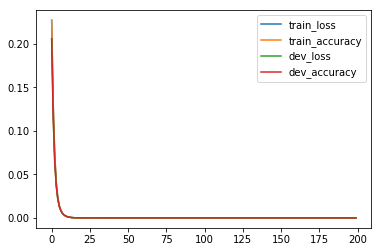

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_62 (Conv1D)           multiple                  2         
_________________________________________________________________
p_attention_99 (pAttention)  multiple                  2         
Total params: 4
Trainable params: 4
Non-trainable params: 0
_________________________________________________________________


In [459]:
import trainers.tf_eager_trainer as trainer

# Run a training batch
tf.set_random_seed(231) # Set seed

# Initialise model and optimiser
model_ = MiniConvRNN(hparams.input_dim, hparams.output_dim, hparams.in_seq_len, hparams.out_seq_len,
                hparams.neurons_unit, hparams.batch_size)
optimizer_ = tf.train.AdamOptimizer(learning_rate = hparams.learning_rate)

# Start training run
loss, accuracy, run_time, stats = trainer.train_model(model_, optimizer_, dataset, hparams,
                                                      epochs=200, verbose=True, dev_dataset=dataset_val)

# Display results
print('Loss {:.4f} Accuracy {:.4f} Time {:.4f}'.format(loss * 10000, accuracy * 10000, run_time))

plt.figure()
for name, stat in stats.items():
    if name != 'time':
        plt.plot(stat, label=name)
plt.legend()
plt.show()

#trainer.save_model(model, optimizer, dataset_val, hparams, 'fd_mini' + get_fields.replace(' ', '_'), stats=stats)
model_.summary()

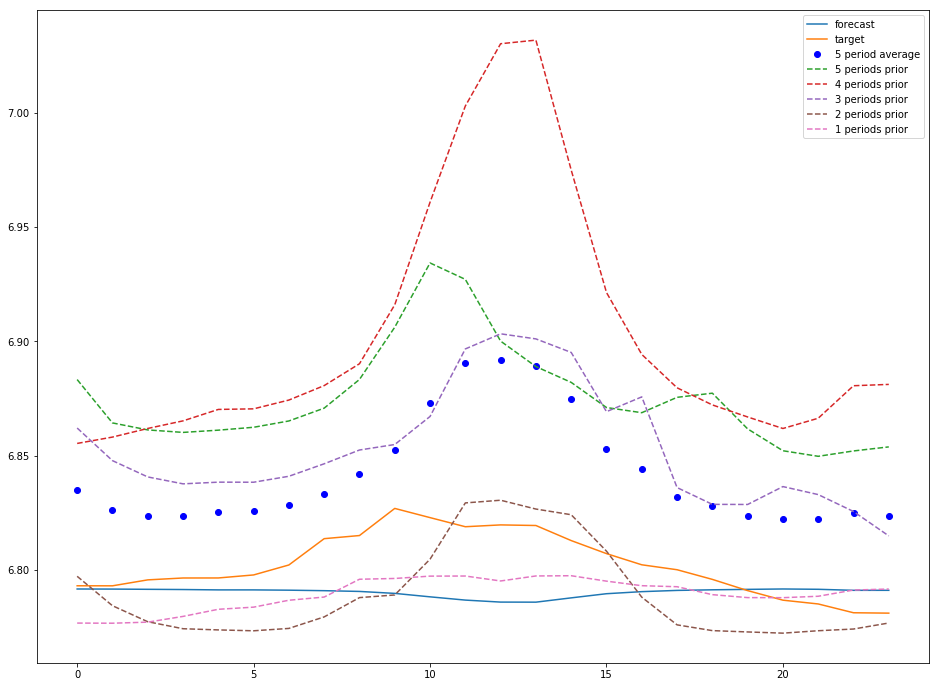

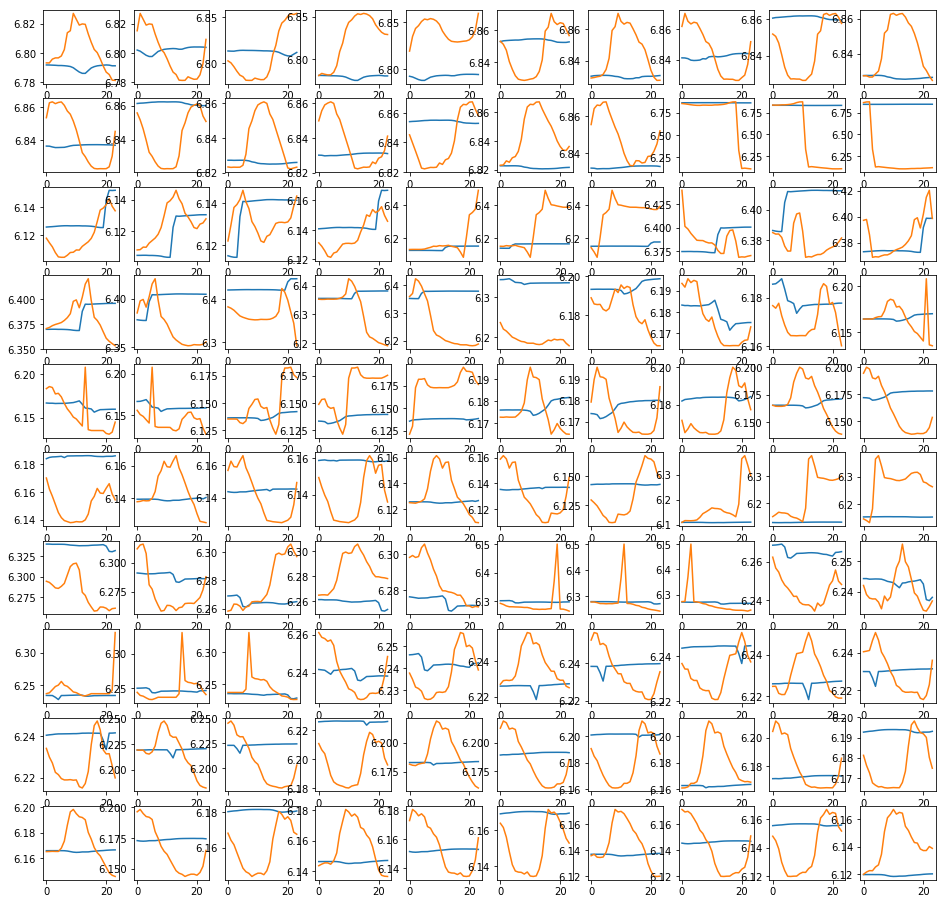

In [460]:
# show all sequences
# Select target sequence to show
TARGET_INDEX = 0

# Create forecast and rescale data
_, (inp, target, mask, x_max) = enumerate(dataset).__next__()
x_max = tf.expand_dims(x_max,-1)
forecast = model_(inp, mask)
forecast *= x_max
target   *= x_max
inp      *= x_max
inp = tf.reshape(inp[:,-120:], [hparams.batch_size, hparams.input_dim, hparams.out_seq_len, -1])
inp = tf.transpose(inp, [0,2,1,3])

# Plot target sequence
plt.figure(figsize=(16,12))
plt.plot(np.squeeze(forecast[TARGET_INDEX,:,0]), label='forecast')
plt.plot(np.squeeze(target[TARGET_INDEX,:,0]), label='target')
plt.plot(np.mean(inp, axis=2)[TARGET_INDEX,:,0], 'bo', label='5 period average')
for i in range(hparams.input_dim):
    plt.plot(np.array(inp)[TARGET_INDEX,:,i,0], '--', label='%i periods prior' % (5-i))
plt.legend()
plt.show()

plt.figure(figsize=(16,16))
for i in range(0,800,8):
    ax = plt.subplot(10,10,i/8+1)
    ax.plot(np.squeeze(forecast[i]), label='forecast')
    ax.plot(np.squeeze(target[i]), label='target')
plt.show()

## Test Hyperparameters

In [152]:
np.random.seed(231)
models, stats = [], []

lr    = np.log10(hparams.learning_rate)
nodes = hparams.neurons_unit

inp, target, mask, x_max = next(iter(dataset))

#for lr in np.random.uniform(-8, -1, 10):
#for nodes in np.floor(2 ** np.arange(3,9)):
for lr in range(-8, 0, 1):
    lr /= 2

    # Run a training batch
    tf.set_random_seed(231) # Set seed

    # Initialise model and optimiser
    model = MiniConvRNN(hparams.input_dim, hparams.output_dim, hparams.in_seq_len, hparams.out_seq_len,
                       hparams.neurons_unit, hparams.batch_size)
    conv1 = model.encode(inp)
    model.conv1_2x1.set_weights([np.array([[[-1.0]], [[ 1.0]]], dtype=np.float32),
                             np.array([0.], dtype=np.float32)])
    optimizer = tf.train.AdamOptimizer(learning_rate = 10 ** lr)

    # Start training run
    loss, accuracy, run_time, stat = \
        trainer.train_model(model, optimizer, dataset, hparams, epochs = 50, verbose=False)
    print('Learning Rate {:.4f} Loss {:.4f} Accuracy {:.4f} Time {:.1f}'.format(lr, loss*10000, accuracy * 10000, run_time))
    
    models.append(model)
    stats.append(stat)

Learning Rate -4.0000 Loss 0.0269 Accuracy 0.0269 Time 12.4
Learning Rate -3.5000 Loss 0.0268 Accuracy 0.0268 Time 12.3
Learning Rate -3.0000 Loss 0.0263 Accuracy 0.0263 Time 12.5
Learning Rate -2.5000 Loss 0.0264 Accuracy 0.0264 Time 13.4
Learning Rate -2.0000 Loss 0.0263 Accuracy 0.0263 Time 13.1
Learning Rate -1.5000 Loss 0.0253 Accuracy 0.0253 Time 13.0
Learning Rate -1.0000 Loss 0.0224 Accuracy 0.0224 Time 12.5
Learning Rate -0.5000 Loss 0.0196 Accuracy 0.0196 Time 14.4
